In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np

# 1. 데이터 로드 및 변수 정의
df = pd.read_csv('df_dropped_dry_data.csv')

# 타겟(Y) 변수
target_col = 'dry_food_brand_pre_tails'

# 특성(X) 변수
feature_cols = [
    'kibble_kcal', 'total_order_kcal', 'pet_breed_size_pre', 'pet_life_pre',
    'neutered_cleaned', 'pet_neutered_pre', 'pet_gender_pre', 'food_funclife_weaning',
    'food_funclife_mature', 'food_funclife_senior', 'pet_health_issue_dig',
    'pet_health_issue_joint', 'pet_health_issue_skin', 'pet_allergen_beef',
    'pet_allergen_chicken', 'pet_allergen_dairy', 'pet_allergen_egg',
    'pet_allergen_lamb', 'pet_allergen_soya', 'pet_allergen_wheat',
    'pet_allergen_fish', 'pet_allergen_grain', 'pet_allergen_maize',
    'neutered_gender_joint', 'neutered_gender_skin', 'neutered_gender_dig',
    'neutered_gender_inner', 'food_funcsize_small', 'food_funcsize_medium',
    'food_funcsize_large', 'food_func_joint', 'food_func_allergy',
    'food_func_skin', 'food_func_dental', 'food_func_losew', 'food_func_dig'
]

# 사용할 데이터프레임
df_model = df[[target_col] + feature_cols].copy()


# --- 전처리 과정 시작 ---

# 2. 타겟 변수 인코딩 (Label Encoding for Multi-class)
le = LabelEncoder()
df_model['y_encoded'] = le.fit_transform(df_model[target_col].astype(str).fillna('Missing'))

# 3. 결측치 처리 (간단한 방법)
# 수치형 변수는 0으로 채우기
numerical_cols = ['kibble_kcal', 'total_order_kcal']
df_model[numerical_cols] = df_model[numerical_cols].fillna(0)

# 범주형 변수는 'Unknown'으로 채우기
categorical_cols = list(set(feature_cols) - set(numerical_cols))
df_model[categorical_cols] = df_model[categorical_cols].astype(str).replace('nan', 'Unknown')
df_model[categorical_cols] = df_model[categorical_cols].astype(str).fillna('Unknown') # 혹시 모를 결측치 최종 처리


# 4. 특성 변수 인코딩 (One-Hot Encoding)
# 범주형 변수에 대해 get_dummies를 적용
X_encoded = pd.get_dummies(df_model[feature_cols], columns=categorical_cols, drop_first=True)

# 최종 X와 Y 정의
X = X_encoded
y = df_model['y_encoded']

# 클래스 개수 확인 (XGBoost Classifier의 num_class 파라미터에 필요)
num_classes = len(y.unique())

# 5. 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. XGBoost 학습
print("--- XGBoost 모델 학습 시작 ---")

# 다중 클래스 분류를 위한 설정
# objective='multi:softmax', num_class=클래스 개수
# tree_method='hist'는 빠른 학습을 위해 사용 (데이터셋 크기에 따라 선택)
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='merror',  # 다중 분류 오류율
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    tree_method='hist'
)

# 모델 학습
model.fit(X_train, y_train)

print("--- XGBoost 모델 학습 완료 ---")


--- XGBoost 모델 학습 시작 ---


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:28:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost 모델 학습 완료 ---


In [4]:
# 7. 예측 및 평가 (선택적)
y_pred = model.predict(X_test)

# 성능 평가 (Accuracy)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"\n테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")

# feature importance (특성 중요도)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- 상위 10개 특성 중요도 ---")
print(top_10_features)

# (참고) 실제 브랜드 이름과 인코딩된 번호의 매핑
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("\n--- 타겟(dry_food_brand_pre_tails) 레이블 매핑 ---")
print(label_mapping)


테스트 데이터 정확도 (Accuracy): 0.9549

--- 상위 10개 특성 중요도 ---
food_funclife_weaning_1    0.158783
food_funclife_mature_1     0.124787
food_func_skin_1           0.123693
food_funcsize_medium_1     0.105021
food_func_joint_1          0.077908
food_func_allergy_1        0.071780
food_func_losew_1          0.068420
food_func_dental_1         0.050381
food_funclife_senior_1     0.050172
food_func_dig_1            0.047631
dtype: float32

--- 타겟(dry_food_brand_pre_tails) 레이블 매핑 ---
{np.int64(0): 'AVA', np.int64(1): 'Acana', np.int64(2): 'Alpha', np.int64(3): 'Arden Grange', np.int64(4): 'Arkwrights', np.int64(5): 'Asda Hero', np.int64(6): 'Autarky', np.int64(7): 'Bakers', np.int64(8): 'Barking Heads', np.int64(9): 'Beneful', np.int64(10): 'Beta', np.int64(11): 'Burns', np.int64(12): 'CSJ', np.int64(13): 'Canagan', np.int64(14): 'Chudleys', np.int64(15): 'Country Kibble', np.int64(16): 'Dr John', np.int64(17): 'Eden', np.int64(18): 'Eukanuba', np.int64(19): 'Feedwell', np.int64(20): 'Friskies', np.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np

# 1. 데이터 및 변수 준비
# 파일을 'df_dropped_dry_data.csv'로 가정합니다.
df = pd.read_csv('df_dropped_dry_data.csv')

# 타겟(Y) 변수
target_col = 'dry_food_brand_pre_tails'

# 특성(X) 변수 (사용자 요청 목록)
feature_cols = [
    'kibble_kcal', 'total_order_kcal', 'pet_breed_size_pre', 'pet_life_pre',
    'neutered_cleaned', 'pet_neutered_pre', 'pet_gender_pre', 'food_funclife_weaning',
    'food_funclife_mature', 'food_funclife_senior', 'pet_health_issue_dig',
    'pet_health_issue_joint', 'pet_health_issue_skin', 'pet_allergen_beef',
    'pet_allergen_chicken', 'pet_allergen_dairy', 'pet_allergen_egg',
    'pet_allergen_lamb', 'pet_allergen_soya', 'pet_allergen_wheat',
    'pet_allergen_fish', 'pet_allergen_grain', 'pet_allergen_maize',
    'neutered_gender_joint', 'neutered_gender_skin', 'neutered_gender_dig',
    'neutered_gender_inner', 'food_funcsize_small', 'food_funcsize_medium',
    'food_funcsize_large', 'food_func_joint', 'food_func_allergy',
    'food_func_skin', 'food_func_dental', 'food_func_losew', 'food_func_dig'
]

# 사용할 데이터프레임
df_model = df[[target_col] + feature_cols].copy()

# --- 전처리 과정 ---

# 2. 타겟 변수 인코딩 (다중 분류를 위해 0부터 시작하는 정수로 변환)
le = LabelEncoder()
# 결측치 방지 및 문자열 변환
df_model['y_encoded'] = le.fit_transform(df_model[target_col].astype(str).fillna('Missing'))

# 3. 결측치 처리 (간단한 방법: 수치형 0, 범주형 'Unknown' 처리)
numerical_cols = ['kibble_kcal', 'total_order_kcal']
df_model[numerical_cols] = df_model[numerical_cols].fillna(0)

categorical_cols = list(set(feature_cols) - set(numerical_cols))
df_model[categorical_cols] = df_model[categorical_cols].astype(str).replace('nan', 'Unknown').fillna('Unknown')


# 4. 범주형 특성 One-Hot Encoding
# drop_first=True로 다중 공선성 문제 방지 (하나의 더미 변수 제거)
X_encoded = pd.get_dummies(df_model[feature_cols], columns=categorical_cols, drop_first=True)

# 최종 X와 Y 정의
X = X_encoded
y = df_model['y_encoded']

# 클래스 개수 (XGBoost 파라미터에 필요)
num_classes = len(y.unique())


# 5. 8:2 비율로 학습 및 테스트 데이터 분리 (test_size=0.2)
# stratify=y를 사용하여 타겟 클래스 비율을 유지하면서 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"총 데이터 개수: {len(X)}")
print(f"학습 데이터 개수 (80%): {len(X_train)}")
print(f"평가 데이터 개수 (20%): {len(X_test)}")


# 6. XGBoost 모델 학습
print("\n--- XGBoost 모델 학습 시작 (80% Train) ---")

model = xgb.XGBClassifier(
    objective='multi:softmax', # 다중 분류 목표 설정
    num_class=num_classes,     # 클래스 개수 지정
    eval_metric='merror',      # 평가 지표: 다중 분류 오류율
    use_label_encoder=False,   # 최신 버전에서는 False 권장
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    tree_method='hist'         # 빠른 학습을 위한 트리 구성 방법
)

# 모델 학습
model.fit(X_train, y_train)

print("--- XGBoost 모델 학습 완료 ---")



총 데이터 개수: 34113
학습 데이터 개수 (80%): 27290
평가 데이터 개수 (20%): 6823

--- XGBoost 모델 학습 시작 (80% Train) ---


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:30:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost 모델 학습 완료 ---


In [6]:
# 7. 예측 및 평가 (20% Test)
y_pred = model.predict(X_test)

# 성능 평가 (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n평가 데이터 (20%) 정확도 (Accuracy): {accuracy:.4f}")

# 특성 중요도 확인 (상위 10개)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- 상위 10개 특성 중요도 ---")
print(top_10_features)

# (참고) 실제 브랜드 이름과 인코딩된 번호의 매핑
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("\n--- 타겟(dry_food_brand_pre_tails) 레이블 매핑 ---")
print(label_mapping)


평가 데이터 (20%) 정확도 (Accuracy): 0.9549

--- 상위 10개 특성 중요도 ---
food_funclife_weaning_1    0.158783
food_funclife_mature_1     0.124787
food_func_skin_1           0.123693
food_funcsize_medium_1     0.105021
food_func_joint_1          0.077908
food_func_allergy_1        0.071780
food_func_losew_1          0.068420
food_func_dental_1         0.050381
food_funclife_senior_1     0.050172
food_func_dig_1            0.047631
dtype: float32

--- 타겟(dry_food_brand_pre_tails) 레이블 매핑 ---
{np.int64(0): 'AVA', np.int64(1): 'Acana', np.int64(2): 'Alpha', np.int64(3): 'Arden Grange', np.int64(4): 'Arkwrights', np.int64(5): 'Asda Hero', np.int64(6): 'Autarky', np.int64(7): 'Bakers', np.int64(8): 'Barking Heads', np.int64(9): 'Beneful', np.int64(10): 'Beta', np.int64(11): 'Burns', np.int64(12): 'CSJ', np.int64(13): 'Canagan', np.int64(14): 'Chudleys', np.int64(15): 'Country Kibble', np.int64(16): 'Dr John', np.int64(17): 'Eden', np.int64(18): 'Eukanuba', np.int64(19): 'Feedwell', np.int64(20): 'Friskies'

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np

# 1. 데이터 및 변수 준비 (이전과 동일)
df = pd.read_csv('df_dropped_dry_data.csv')

target_col = 'dry_food_brand_pre_tails'
feature_cols = [
    'kibble_kcal', 'total_order_kcal', 'pet_breed_size_pre', 'pet_life_pre',
    'neutered_cleaned', 'pet_neutered_pre', 'pet_gender_pre', 'food_funclife_weaning',
    'food_funclife_mature', 'food_funclife_senior', 'pet_health_issue_dig',
    'pet_health_issue_joint', 'pet_health_issue_skin', 'pet_allergen_beef',
    'pet_allergen_chicken', 'pet_allergen_dairy', 'pet_allergen_egg',
    'pet_allergen_lamb', 'pet_allergen_soya', 'pet_allergen_wheat',
    'pet_allergen_fish', 'pet_allergen_grain', 'pet_allergen_maize',
    'neutered_gender_joint', 'neutered_gender_skin', 'neutered_gender_dig',
    'neutered_gender_inner', 'food_funcsize_small', 'food_funcsize_medium',
    'food_funcsize_large', 'food_func_joint', 'food_func_allergy',
    'food_func_skin', 'food_func_dental', 'food_func_losew', 'food_func_dig'
]

df_model = df[[target_col] + feature_cols].copy()

# 2. 전처리 (이전과 동일)
le = LabelEncoder()
df_model['y_encoded'] = le.fit_transform(df_model[target_col].astype(str).fillna('Missing'))

numerical_cols = ['kibble_kcal', 'total_order_kcal']
df_model[numerical_cols] = df_model[numerical_cols].fillna(0)

categorical_cols = list(set(feature_cols) - set(numerical_cols))
df_model[categorical_cols] = df_model[categorical_cols].astype(str).replace('nan', 'Unknown').fillna('Unknown')

X_encoded = pd.get_dummies(df_model[feature_cols], columns=categorical_cols, drop_first=True)
X = X_encoded
y = df_model['y_encoded']
num_classes = len(y.unique())

# 3. 8:2 비율로 학습 및 테스트 데이터 분리 (이전과 동일)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 4. 🔥 2차 조정된 하이퍼파라미터로 XGBoost 모델 학습 (규제 극대화)
print("--- 2차 조정된 XGBoost 모델 학습 시작 (규제 극대화) ---")

model_tuned_2 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='merror',
    use_label_encoder=False,
    random_state=42,
    tree_method='hist',
    
    # ======== 2차 조정된 파라미터: 규제 강화 ========
    n_estimators=500,        # 트리를 더 늘림
    learning_rate=0.02,      # 학습률을 더 낮춤
    max_depth=2,             # 트리의 깊이를 2로 제한
    subsample=0.8,           # 학습에 사용할 데이터 샘플링 비율
    colsample_bytree=0.6,    # 각 트리를 만들 때 사용할 특성 샘플링 비율 (새로 추가)
    gamma=0.5,               # 최소 손실 감소량 임계치 유지
    # ============================================
)

# 모델 학습
model_tuned_2.fit(X_train, y_train)

print("--- 2차 조정된 XGBoost 모델 학습 완료 ---")

# 5. 예측 및 평가
y_train_pred = model_tuned_2.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = model_tuned_2.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n✅ 2차 조정 모델 학습 데이터 (80%) 정확도: {train_accuracy:.4f}")
print(f"✅ 2차 조정 모델 평가 데이터 (20%) 정확도: {test_accuracy:.4f}")

# 특성 중요도 확인
feature_importances = pd.Series(model_tuned_2.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- 상위 10개 특성 중요도 (2차 조정 후) ---")
print(top_10_features)

--- 2차 조정된 XGBoost 모델 학습 시작 (규제 극대화) ---


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:33:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- 2차 조정된 XGBoost 모델 학습 완료 ---

✅ 2차 조정 모델 학습 데이터 (80%) 정확도: 0.9391
✅ 2차 조정 모델 평가 데이터 (20%) 정확도: 0.9393

--- 상위 10개 특성 중요도 (2차 조정 후) ---
food_funclife_weaning_1    0.120750
food_funclife_mature_1     0.112151
food_func_skin_1           0.083098
food_funcsize_medium_1     0.082651
food_func_allergy_1        0.070845
food_func_dental_1         0.058184
food_func_losew_1          0.054896
food_func_joint_1          0.053574
food_funclife_senior_1     0.051472
food_func_dig_1            0.047595
dtype: float32


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np

# 1. 데이터 및 변수 준비
df = pd.read_csv('df_dropped_dry_data.csv')

target_col = 'dry_food_brand_pre_tails'

feature_cols_to_remove = [
    'food_funclife_weaning', 'food_funclife_senior', 
    'food_func_allergy'
]

original_feature_cols = [
    'kibble_kcal', 'total_order_kcal', 'pet_breed_size_pre', 'pet_life_pre',
    'neutered_cleaned', 'pet_neutered_pre', 'pet_gender_pre', 'food_funclife_weaning',
    'food_funclife_mature', 'food_funclife_senior', 'pet_health_issue_dig',
    'pet_health_issue_joint', 'pet_health_issue_skin', 'pet_allergen_beef',
    'pet_allergen_chicken', 'pet_allergen_dairy', 'pet_allergen_egg',
    'pet_allergen_lamb', 'pet_allergen_soya', 'pet_allergen_wheat',
    'pet_allergen_fish', 'pet_allergen_grain', 'pet_allergen_maize',
    'neutered_gender_joint', 'neutered_gender_skin', 'neutered_gender_dig',
    'neutered_gender_inner', 'food_funcsize_small', 'food_funcsize_medium',
    'food_funcsize_large', 'food_func_joint', 'food_func_allergy',
    'food_func_skin', 'food_func_dental', 'food_func_losew', 'food_func_dig'
]

feature_cols_clean = [col for col in original_feature_cols if col not in feature_cols_to_remove]
df_model = df[[target_col] + feature_cols_clean].copy()


# 2. 전처리
le = LabelEncoder()
df_model['y_encoded'] = le.fit_transform(df_model[target_col].astype(str).fillna('Missing'))

numerical_cols = ['kibble_kcal', 'total_order_kcal']
current_numerical_cols = [col for col in numerical_cols if col in df_model.columns]
df_model[current_numerical_cols] = df_model[current_numerical_cols].fillna(0)

categorical_cols = list(set(feature_cols_clean) - set(current_numerical_cols))
df_model[categorical_cols] = df_model[categorical_cols].astype(str).replace('nan', 'Unknown').fillna('Unknown')

X_encoded = pd.get_dummies(df_model[feature_cols_clean], columns=categorical_cols, drop_first=True)
X = X_encoded
y = df_model['y_encoded']
num_classes = len(y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("3차")

model_final = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='merror',
    use_label_encoder=False,
    random_state=42,
    tree_method='hist',
    
    # 2차 조정 파라미터 유지
    n_estimators=500,
    learning_rate=0.02,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0.5,
)

# 모델 학습
model_final.fit(X_train, y_train)

print("완")

# 5. 예측 및 평가
y_train_pred = model_final.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = model_final.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n 학습 데이터 (80%) 정확도: {train_accuracy:.4f}")
print(f"모델 평가 데이터 (20%) 정확도: {test_accuracy:.4f}")

# 특성 중요도 확인
feature_importances = pd.Series(model_final.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- 상위 10개 특성 중요도 (3차 조정 후) ---")
print(top_10_features)

--- 3차 조정된 XGBoost 모델 학습 시작 (선택적 변수 제거) ---


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:58:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- 3차 조정된 XGBoost 모델 학습 완료 ---

✅ 3차 조정 모델 학습 데이터 (80%) 정확도: 0.8562
✅ 3차 조정 모델 평가 데이터 (20%) 정확도: 0.8518

--- 상위 10개 특성 중요도 (3차 조정 후) ---
food_funclife_mature_1    0.122007
food_func_skin_1          0.110698
food_funcsize_medium_1    0.105528
food_func_joint_1         0.075106
food_func_dental_1        0.072244
food_func_losew_1         0.067806
food_func_dig_1           0.065180
food_funcsize_small_1     0.058859
food_funcsize_large_1     0.042279
pet_allergen_soya_1       0.031928
dtype: float32


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import numpy as np

# 1. 데이터 및 변수 준비 (기존 코드 유지)
df = pd.read_csv('df_dropped_dry_data.csv')

target_col = 'dry_food_brand_pre_tails'

feature_cols_to_remove = [
    'food_funclife_weaning', 'food_funclife_senior', 
    'food_func_allergy'
]

original_feature_cols = [
    'kibble_kcal', 'total_order_kcal', 'pet_breed_size_pre', 'pet_life_pre',
    'neutered_cleaned', 'pet_neutered_pre', 'pet_gender_pre', 'food_funclife_weaning',
    'food_funclife_mature', 'food_funclife_senior', 'pet_health_issue_dig',
    'pet_health_issue_joint', 'pet_health_issue_skin', 'pet_allergen_beef',
    'pet_allergen_chicken', 'pet_allergen_dairy', 'pet_allergen_egg',
    'pet_allergen_lamb', 'pet_allergen_soya', 'pet_allergen_wheat',
    'pet_allergen_fish', 'pet_allergen_grain', 'pet_allergen_maize',
    'neutered_gender_joint', 'neutered_gender_skin', 'neutered_gender_dig',
    'neutered_gender_inner', 'food_funcsize_small', 'food_funcsize_medium',
    'food_funcsize_large', 'food_func_joint', 'food_func_allergy',
    'food_func_skin', 'food_func_dental', 'food_func_losew', 'food_func_dig'
]

feature_cols_clean = [col for col in original_feature_cols if col not in feature_cols_to_remove]
df_model = df[[target_col] + feature_cols_clean].copy()


# 2. 전처리 및 데이터 분할 (기존 코드 유지)
le = LabelEncoder()
df_model['y_encoded'] = le.fit_transform(df_model[target_col].astype(str).fillna('Missing'))

# LabelEncoder의 클래스 이름을 저장
target_names = le.classes_ 

numerical_cols = ['kibble_kcal', 'total_order_kcal']
current_numerical_cols = [col for col in numerical_cols if col in df_model.columns]
df_model[current_numerical_cols] = df_model[current_numerical_cols].fillna(0)

categorical_cols = list(set(feature_cols_clean) - set(current_numerical_cols))
df_model[categorical_cols] = df_model[categorical_cols].astype(str).replace('nan', 'Unknown').fillna('Unknown')

X_encoded = pd.get_dummies(df_model[feature_cols_clean], columns=categorical_cols, drop_first=True)
X = X_encoded
y = df_model['y_encoded']
num_classes = len(y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("3차")

# 3. 모델 정의 및 학습 (기존 코드 유지)
model_final = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='merror',
    use_label_encoder=False,
    random_state=42,
    tree_method='hist',
    
    # 2차 조정 파라미터 유지
    n_estimators=500,
    learning_rate=0.02,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0.5,
)

# 모델 학습
model_final.fit(X_train, y_train)

print("완")

# 4. 예측 및 기본 평가 (정확도)
y_train_pred = model_final.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = model_final.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n✅ 학습 데이터 (80%) **정확도 (Accuracy)**: {train_accuracy:.4f}")
print(f"✅ 모델 평가 데이터 (20%) **정확도 (Accuracy)**: {test_accuracy:.4f}")

# --- 추가된 평가 지표 (Classification Report) ---
print("\n" + "="*50)
print("## 📋 테스트 데이터셋 **분류 보고서 (Classification Report)**")
print("="*50)

# 5. 상세 평가 지표 출력
# target_names: LabelEncoder를 통해 얻은 실제 클래스 이름 (브랜드 이름)
print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0))

print("\n" + "="*50)
print("## 🔢 테스트 데이터셋 **혼동 행렬 (Confusion Matrix)**")
print("="*50)

# 6. 혼동 행렬 출력
print(confusion_matrix(y_test, y_test_pred))

# 7. 특성 중요도 확인 (기존 코드 유지)
feature_importances = pd.Series(model_final.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- 상위 10개 특성 중요도 (3차 조정 후) ---")
print(top_10_features)

3차


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:46:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


완

✅ 학습 데이터 (80%) **정확도 (Accuracy)**: 0.8565
✅ 모델 평가 데이터 (20%) **정확도 (Accuracy)**: 0.8520

## 📋 테스트 데이터셋 **분류 보고서 (Classification Report)**
                                 precision    recall  f1-score   support

                            AVA       0.71      0.04      0.08       240
                          Acana       0.00      0.00      0.00        33
                          Alpha       0.96      1.00      0.98        23
                   Arden Grange       1.00      1.00      1.00       146
                     Arkwrights       1.00      1.00      1.00        19
                      Asda Hero       1.00      1.00      1.00       252
                        Autarky       1.00      1.00      1.00        35
                         Bakers       0.70      0.94      0.80       861
                  Barking Heads       1.00      1.00      1.00        68
                        Beneful       0.75      1.00      0.86        89
                           Beta       1.00      1.00    

In [13]:
from sklearn.metrics import accuracy_score, f1_score

# 전체 정확도 (Accuracy)
test_accuracy = accuracy_score(y_test, y_test_pred)

# 가중 평균 F1 점수 (Weighted Average F1-Score)
# 다중 클래스 분류 및 불균형 데이터에 적합
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

print(f"✅ 모델 평가 데이터 전체 정확도: {test_accuracy:.4f}")
print(f"✅ 모델 평가 데이터 가중 평균 F1-Score: {weighted_f1:.4f}")

✅ 모델 평가 데이터 전체 정확도: 0.8520
✅ 모델 평가 데이터 가중 평균 F1-Score: 0.8152


C:\Users\user\AppData\Local\Temp\ipykernel_8964\4251487464.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  green_map = plt.cm.get_cmap('Greens')


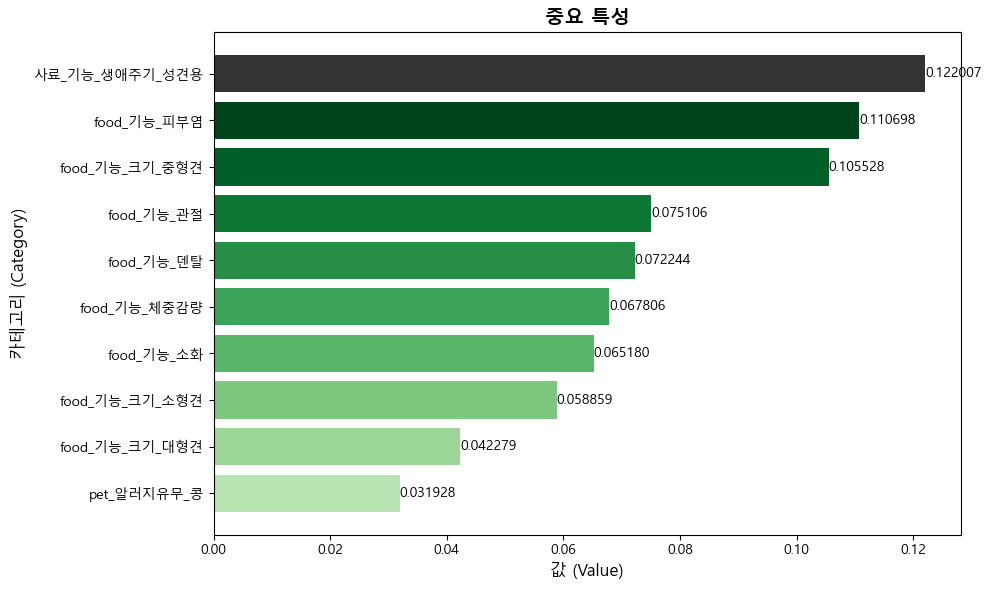

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from matplotlib.colors import Normalize

# 1. 폰트 설정 (Windows 환경 - 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 2. 사용자 입력 데이터
data_string = """사료_기능_생애주기_성견용    0.122007
food_기능_피부염          0.110698
food_기능_크기_중형견    0.105528
food_기능_관절         0.075106
food_기능_덴탈        0.072244
food_기능_체중감량         0.067806
food_기능_소화           0.065180
food_기능_크기_소형견     0.058859
food_기능_크기_대형견     0.042279
pet_알러지유무_콩       0.031928
"""

# 3. 데이터 파싱 및 DataFrame 생성
data = []
for line in data_string.strip().split('\n'):
    parts = line.split()
    if len(parts) == 2:
        category = parts[0]
        try:
            value = float(parts[1])
            data.append({'Category': category, 'Value': value})
        except ValueError:
            continue

df = pd.DataFrame(data)
# 값이 큰 순서대로 정렬 (가장 큰 값이 맨 위에 오도록)
df_sorted = df.sort_values(by='Value', ascending=False).reset_index(drop=True)

# 4. 색상 설정 로직
N = len(df_sorted)
colors = []
# 제일 큰 막대 색상: 연한 검정색 (짙은 회색)
LIGHT_BLACK = '#333333' 
colors.append(LIGHT_BLACK)

# 4-1. 나머지 막대 (두 번째부터)에 녹색 그라데이션 적용
# Greens 맵을 사용하여 채도가 높은 녹색에서 시작하여 채도를 점점 뺍니다.
green_map = plt.cm.get_cmap('Greens') 

# 두 번째 막대부터 마지막 막대까지 (N-1개의 막대)에 색상을 적용합니다.
# 두 번째 막대 (인덱스 1)가 가장 진한 녹색이 되고, 값이 작아질수록 연해져야 합니다.
# Greens 맵은 숫자가 높을수록 진합니다.
# 1.0 (가장 진한 녹색)에서 0.3 (가장 연한 녹색) 사이의 톤을 사용합니다.
start_color_norm = 1.0  # 가장 진한 녹색
end_color_norm = 0.3    # 가장 연한 녹색

for i in range(1, N):
    # 인덱스가 1일 때 (두 번째 막대) 1.0에 가까운 값, 인덱스가 N-1일 때 0.3에 가까운 값이 나와야 합니다.
    # 즉, 1에서 N-1까지 거리가 멀어질수록 값이 감소해야 합니다.
    normalized_value = start_color_norm - (i - 1) * ((start_color_norm - end_color_norm) / (N - 2))
    colors.append(green_map(normalized_value))

# 5. 시각화
plt.figure(figsize=(10, 6))

bars = plt.barh(df_sorted['Category'], df_sorted['Value'], color=colors)

# 레이블 및 제목 추가
plt.xlabel('값 (Value)', fontsize=12)
plt.ylabel('카테고리 (Category)', fontsize=12)
plt.title('중요 특성', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis() # 값이 큰 순서대로 위에서 아래로 표시

# 6. 막대에 값 레이블 추가
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.6f}',
             va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show() # 결과 확인용
